In [2]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import pandas as pd

import seaborn as sns
raw = load_iris(as_frame=True)
df = pd.DataFrame(raw.data)
df["target"] = raw.target
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df.target)
df = pd.DataFrame(train)
test = pd.DataFrame(test)

In [5]:
pivoted = df.melt(
  value_vars=[
    "sepal length (cm)",
    "sepal width (cm)",
    "petal length (cm)",
    "petal width (cm)"
    ],
    id_vars=[
      "target"
    ]
  )
pivoted

,target,variable,value
0,1,sepal length (cm),5.5
1,1,sepal length (cm),5.5
2,0,sepal length (cm),4.6
3,0,sepal length (cm),5.7
4,2,sepal length (cm),6.0
...,...,...,...
475,0,petal width (cm),0.4
476,0,petal width (cm),0.2
477,1,petal width (cm),1.5
478,1,petal width (cm),1.4


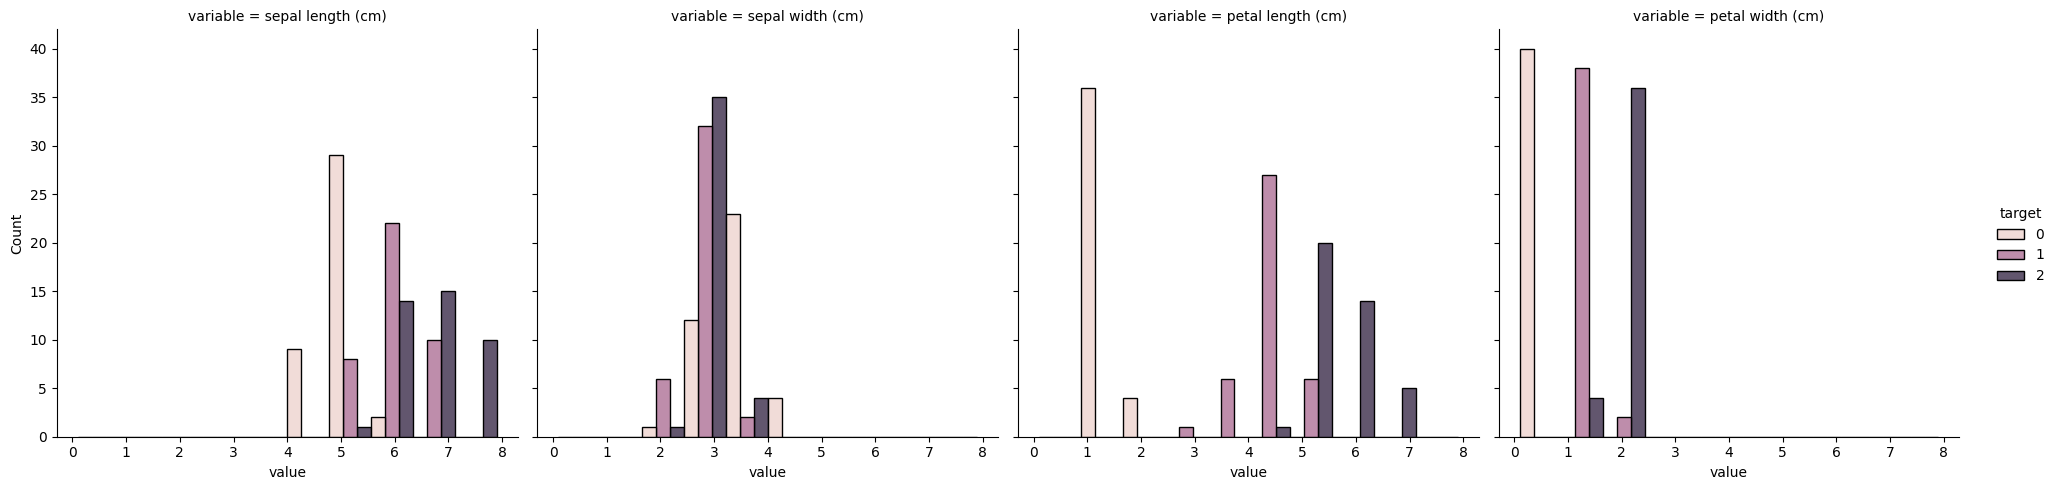

In [6]:
sns.displot(
  pivoted, 
  x="value",
  hue="target",
  multiple="dodge",
  col="variable",
)

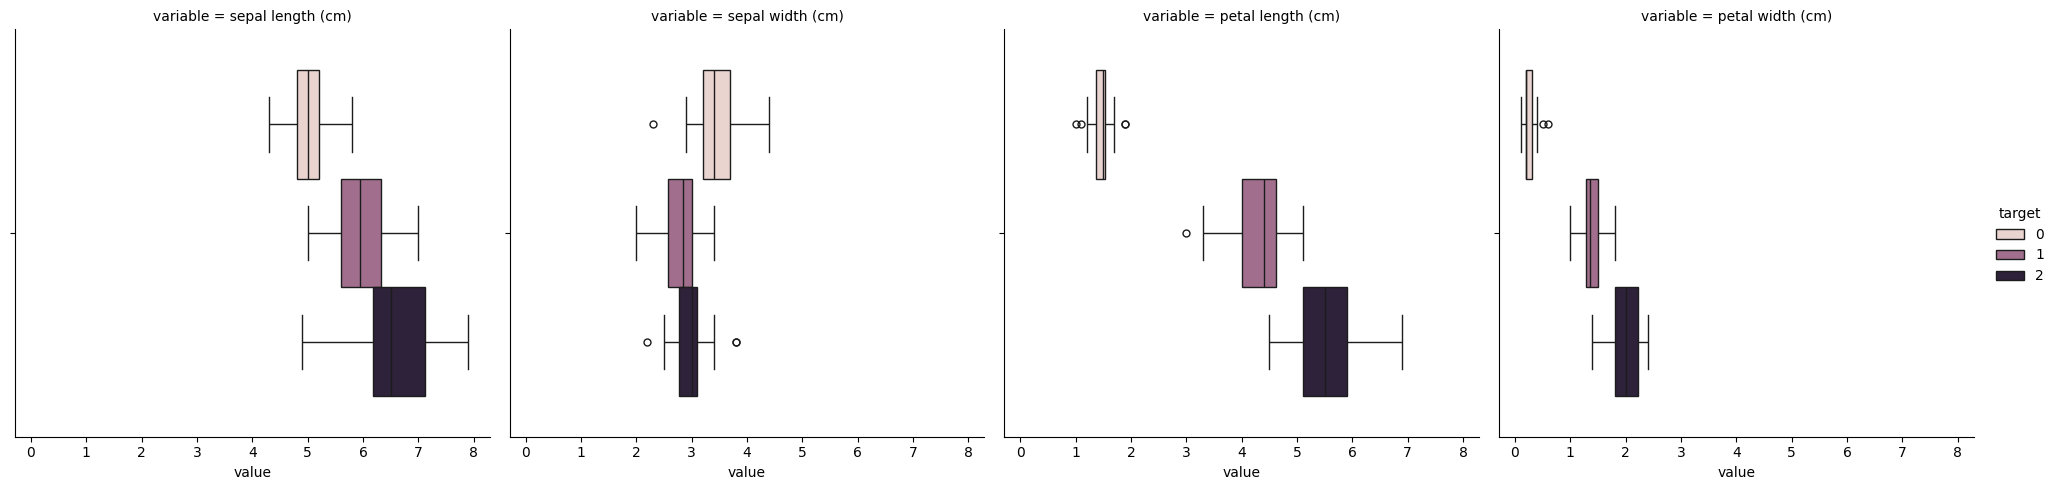

In [7]:
sns.catplot(
  pivoted, 
  x="value",
  hue="target",
  kind="box",
  col="variable",
)

In [8]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import make_scorer
import numpy as np

kss_pipe = Pipeline([
  ("scale", StandardScaler()),
  ("pca", PCA()),
  ("knn", KNeighborsClassifier())
])
kqt_pipe = Pipeline([
  ("scale", QuantileTransformer(n_quantiles=100)),
  ("pca", PCA()),
  ("knn", KNeighborsClassifier())
])
kmm_pipe = Pipeline([
  ("scale", MinMaxScaler()),
  ("pca", PCA()),
  ("knn", KNeighborsClassifier())
])

from functools import partial
MyGridSearch = partial(
    GridSearchCV,
    param_grid={
      "knn__n_neighbors": np.arange(1, 10, 1)
    },
    cv=10,
    scoring={
      "f1_score": make_scorer(f1_score, average="macro"), 
      "accuracy_score": make_scorer(accuracy_score), 
      "recall_score": make_scorer(recall_score, average="macro"),
    },
    refit="f1_score",
    return_train_score=True,
)

kss_search = MyGridSearch(
  estimator=kss_pipe,
)
kqt_search = MyGridSearch(
  estimator=kqt_pipe,
)
kmm_search = MyGridSearch(
  estimator=kmm_pipe,
)

In [9]:
cols = set(df.columns)
cols.remove("target")
cols = list(cols)
X, y = df[cols], df["target"]
kss_info = kss_search.fit(X, y)
kqt_info = kqt_search.fit(X, y)
kmm_info = kmm_search.fit(X, y)

In [10]:
kss_info_df = pd.DataFrame({**kss_info.cv_results_, "name": "standard"})
kqt_info_df = pd.DataFrame({**kqt_info.cv_results_, "name": "quantile"})
kmm_info_df = pd.DataFrame({**kmm_info.cv_results_, "name": "minmax"})
knn_results = pd.concat([kss_info_df, kqt_info_df, kmm_info_df])
knn_results[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,...,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score,name
0,0.005963,0.006259,0.007582,0.001017,1,{'knn__n_neighbors': 1},0.833333,0.915344,0.750361,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,standard
1,0.003855,0.000425,0.007380,0.000564,2,{'knn__n_neighbors': 2},0.833333,0.915344,0.822222,1.0,...,0.962963,0.962963,0.962963,0.962963,0.972222,0.962963,0.962963,0.966667,0.006142,standard
2,0.003781,0.000397,0.007022,0.000354,3,{'knn__n_neighbors': 3},0.833333,0.915344,0.822222,1.0,...,0.935185,0.935185,0.935185,0.944444,0.944444,0.935185,0.953704,0.946296,0.010798,standard
3,0.003575,0.000248,0.006947,0.000398,4,{'knn__n_neighbors': 4},0.833333,0.915344,0.822222,1.0,...,0.944444,0.944444,0.935185,0.944444,0.953704,0.944444,0.953704,0.950926,0.009305,standard
4,0.003740,0.000528,0.006997,0.000518,5,{'knn__n_neighbors': 5},0.833333,0.915344,0.915344,1.0,...,0.962963,0.953704,0.944444,0.953704,0.972222,0.962963,0.962963,0.961111,0.008072,standard
5,0.004021,0.000565,0.007172,0.000470,6,{'knn__n_neighbors': 6},0.915344,0.915344,0.915344,1.0,...,0.953704,0.953704,0.944444,0.953704,0.972222,0.953704,0.962963,0.956481,0.007232,standard
6,0.003668,0.000376,0.006893,0.000477,7,{'knn__n_neighbors': 7},0.915344,0.915344,0.833333,1.0,...,0.944444,0.944444,0.944444,0.944444,0.972222,0.944444,0.962963,0.954630,0.010516,standard
7,0.003647,0.000432,0.007058,0.000395,8,{'knn__n_neighbors': 8},0.915344,0.915344,0.915344,1.0,...,0.944444,0.962963,0.935185,0.944444,0.972222,0.953704,0.962963,0.956481,0.011749,standard
8,0.003619,0.000345,0.006889,0.000678,9,{'knn__n_neighbors': 9},0.915344,0.915344,0.833333,1.0,...,0.935185,0.944444,0.953704,0.944444,0.962963,0.953704,0.972222,0.953704,0.010956,standard
0,0.004670,0.000591,0.007002,0.000314,1,{'knn__n_neighbors': 1},0.915344,0.915344,0.750361,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,quantile


In [11]:
knn_results = knn_results.explode("params")
# Melt the DataFrame
piv_knn_results = knn_results.melt(
    id_vars=["name", "param_knn__n_neighbors"],
    value_vars=[col for col in knn_results.columns if 'split' in col],
    var_name='fold', value_name='score'
)
def fold_map(x):
  values = x.split("_")
  return {"split": values[0][5:], "type": values[1], "metric": "_".join(values[2:])}
piv_knn_results["fold"] = piv_knn_results["fold"].map(fold_map)
piv_knn_results = pd.concat([piv_knn_results, piv_knn_results["fold"].apply(pd.Series)], axis=1)
piv_knn_results[:10]

,name,param_knn__n_neighbors,fold,score,split,type,metric
0,standard,1,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.833333,0,test,f1_score
1,standard,2,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.833333,0,test,f1_score
2,standard,3,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.833333,0,test,f1_score
3,standard,4,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.833333,0,test,f1_score
4,standard,5,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.833333,0,test,f1_score
5,standard,6,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.915344,0,test,f1_score
6,standard,7,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.915344,0,test,f1_score
7,standard,8,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.915344,0,test,f1_score
8,standard,9,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.915344,0,test,f1_score
9,quantile,1,"{'split': '0', 'type': 'test', 'metric': 'f1_s...",0.915344,0,test,f1_score


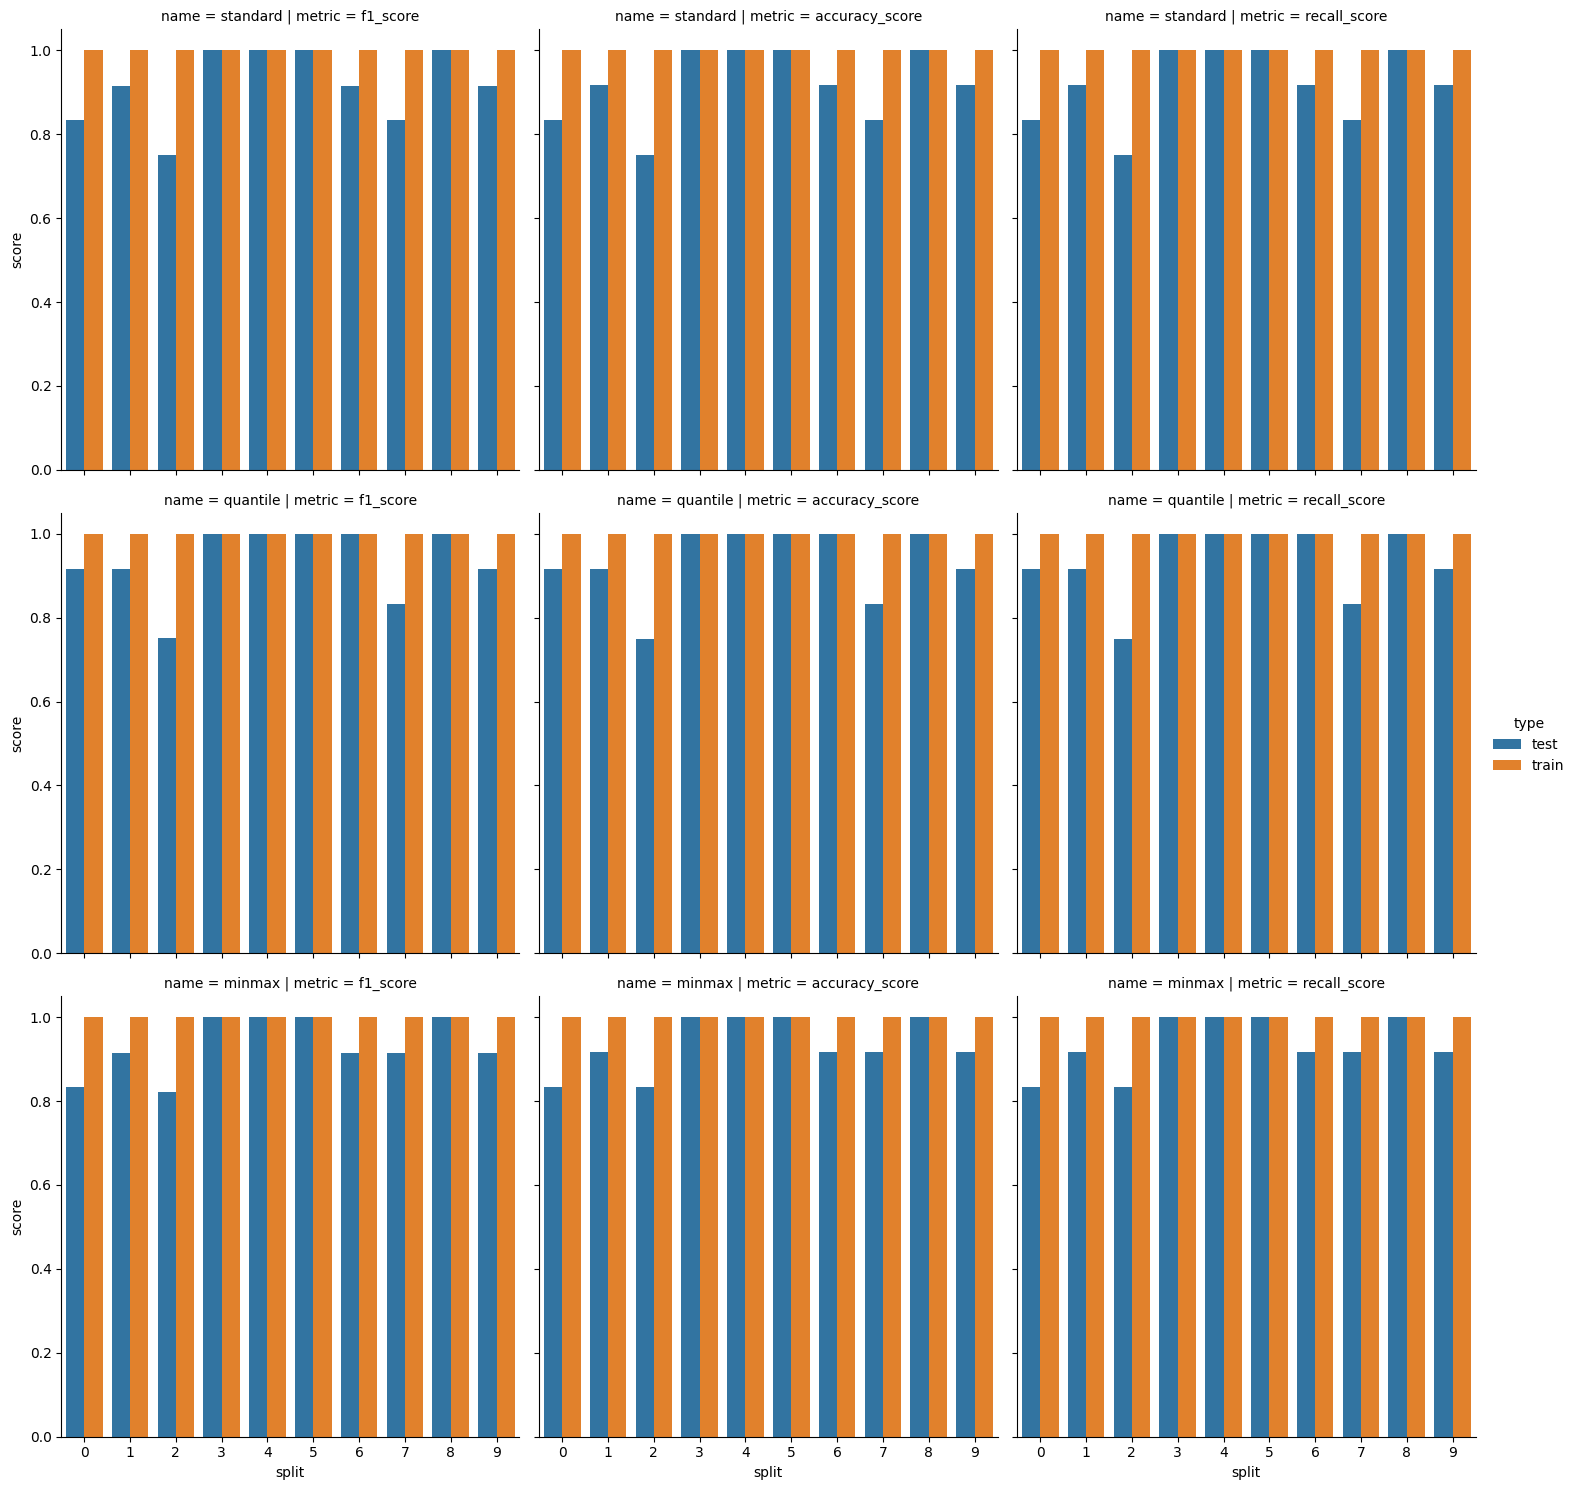

In [12]:
sns.catplot(
  piv_knn_results[piv_knn_results["param_knn__n_neighbors"] == 1], 
  x="split", 
  y="score",
  col="metric",
  row="name",
  kind="bar",
  hue="type",
)

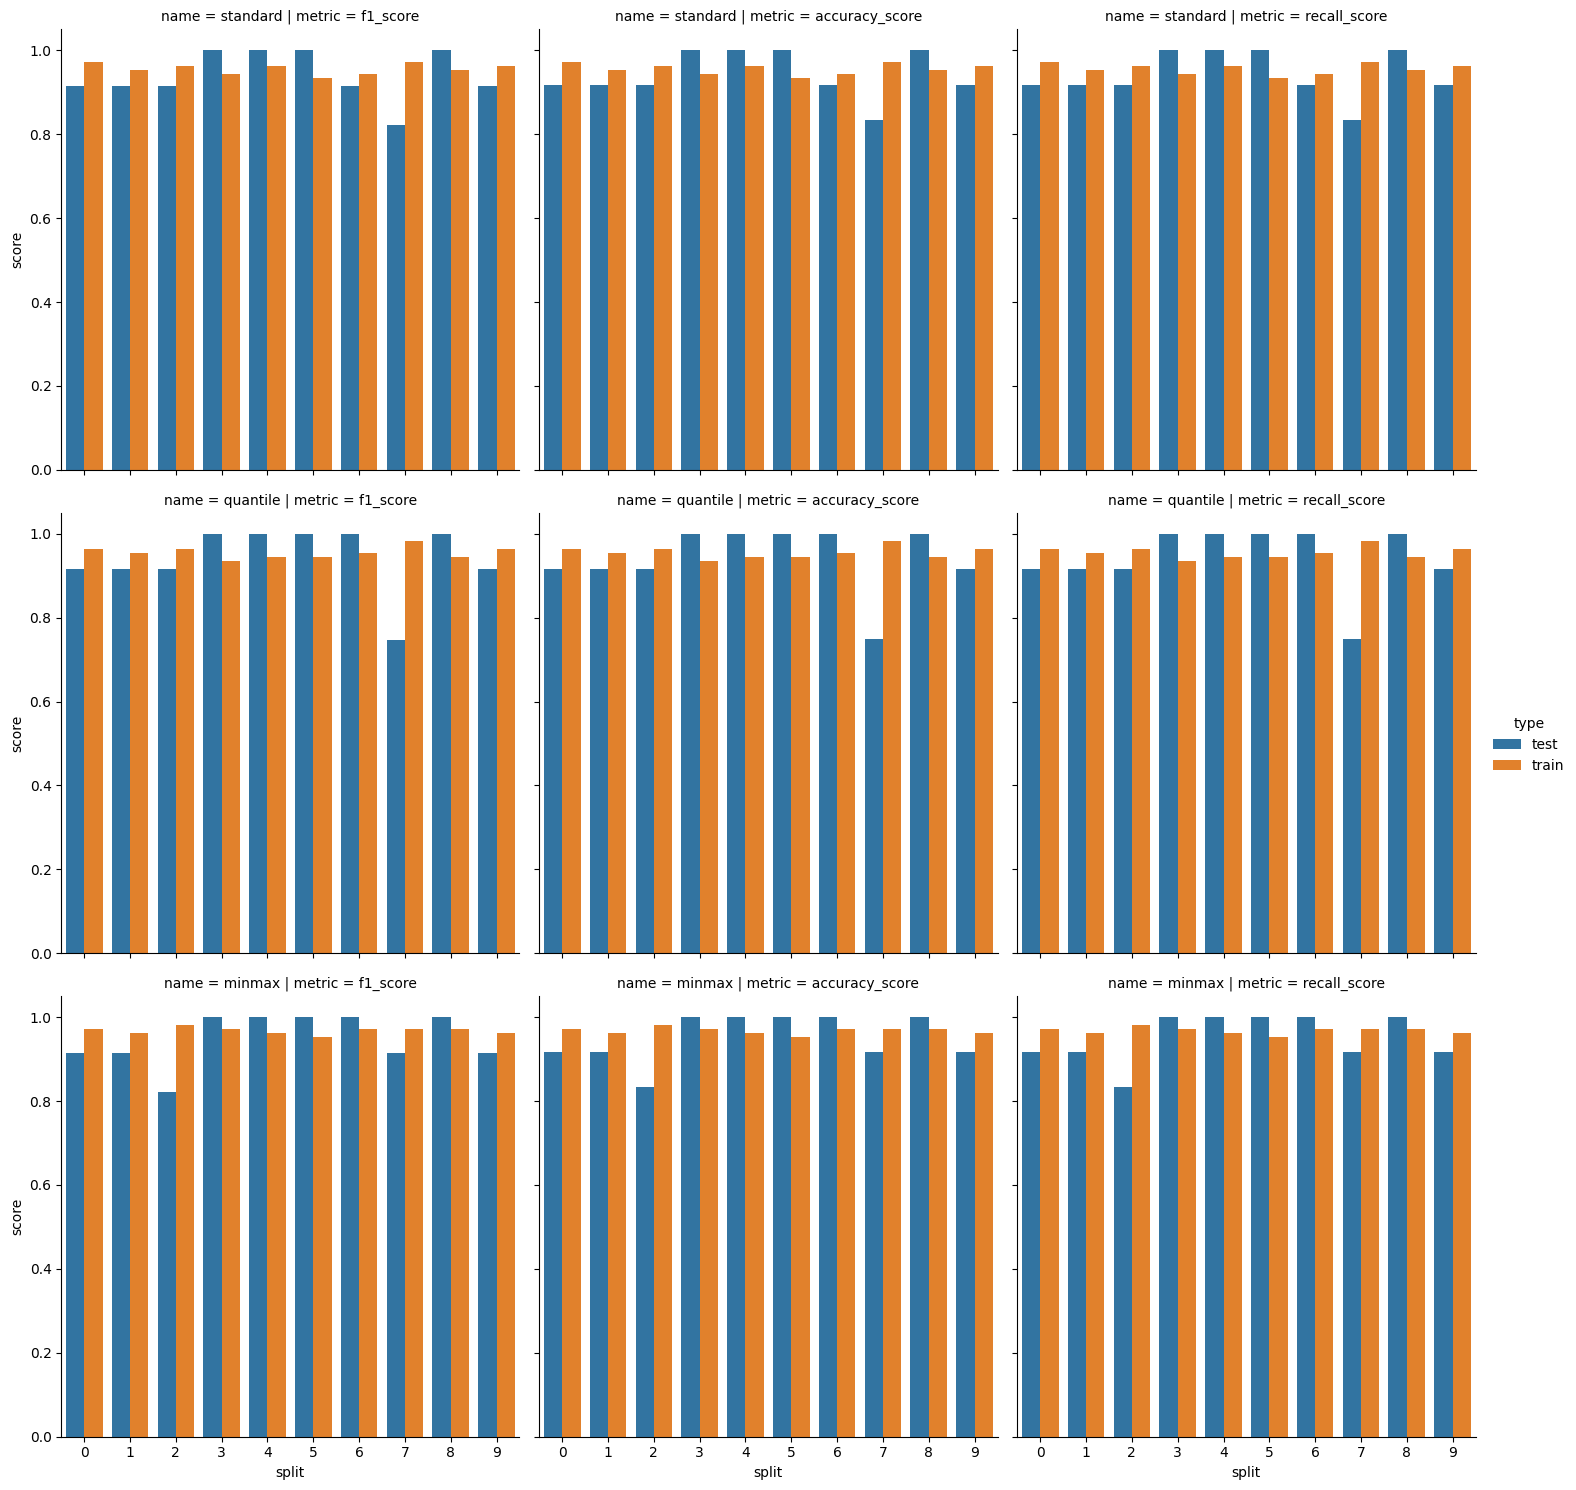

In [13]:
sns.catplot(
  piv_knn_results[piv_knn_results["param_knn__n_neighbors"] == 8], 
  x="split", 
  y="score",
  col="metric",
  row="name",
  kind="bar",
  hue="type",
)

In [14]:
sum_piv = piv_knn_results[
  (piv_knn_results["type"] == "test") & (piv_knn_results["metric"] == "f1_score")
].groupby(["name", "param_knn__n_neighbors"]).mean("score")
sum_piv["rank"] = sum_piv.groupby(["name"]).rank(method="first", ascending = False)["score"]
sum_piv[sum_piv["rank"] == 1]

,,score,rank
name,param_knn__n_neighbors,,
minmax,6,0.956825,1.0
quantile,3,0.958413,1.0
standard,9,0.941005,1.0


In [20]:
kqt_cm = confusion_matrix(kqt_search.best_estimator_.predict(Xt), yt)
kqt_cm

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]])

<Axes: >

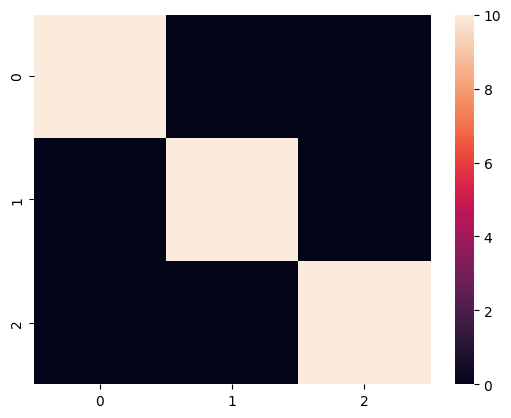

In [18]:
sns.heatmap(kqt_cm)